In [1]:
import sys
from __future__ import print_function, division
import pprint
import pandas as pd
import numpy as np
import csv
import re
import nltk
from gensim import corpora, models, similarities, matutils
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, RegexpTokenizer
from nltk.util import ngrams
from nltk import pos_tag, everygrams
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.decomposition import NMF
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import Normalizer
from nltk.stem import WordNetLemmatizer, PorterStemmer
from nltk.stem.snowball import SnowballStemmer
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
from wordcloud import WordCloud
import spacy
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn import svm

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('whitegrid')
%matplotlib inline


In [2]:
pd.set_option('display.max_colwidth', -1)
cri_df = pd.read_csv('total_comedy_reviews.csv', index_col=0)
aud_df = pd.read_csv('total_aud_reviews.csv', index_col=0)

In [3]:
cri_df['type'] = 'critic'
aud_df['type'] = 'audience'

In [4]:
df = cri_df.append(aud_df)
# df.tail()
# df.shape

In [6]:
df['review'] = df['review'].apply(lambda x: " ".join(x.lower() for x in x.split())) #lowercase
df['review'] = df['review'].str.replace('[^\w\s]',' ') #removing numbers
df = df.replace('\n',' ', regex=True) #removing \n tag
stop = stopwords.words('english')
df['review'] = df['review'].apply(lambda x: " ".join(x for x in x.split() if x not in stop)) #remove stopwords


In [7]:
# lemmatizing words
lemma = WordNetLemmatizer() 
def stem_sentences(sentence):
    tokens = sentence.split()
    stemmed_tokens = [lemma.lemmatize(token) for token in tokens]
    return ' '.join(stemmed_tokens)

df['review'] = df['review'].apply(stem_sentences)

In [11]:
df['pos'] = nltk.pos_tag_sents(df['review'].apply(word_tokenize))

In [12]:
# df.head(5)
# df.shape

In [13]:
def get_noun(row):
    foo = [word for (word, pos) in row if pos == 'NN']
    s = ' '
    s = s.join(foo)
    return foo

In [14]:
df['pos'].map(lambda x: get_noun(x))

0       [goof, love, movie, cast, character, stretch]                                                                                                                                                                                                                                                                                                                                                                                                        
1       [pegg, gaggle, genre]                                                                                                                                                                                                                                                                                                                                                                                                                                
2       [movie, duly, pursuit, speed, homage, action, thriller, detail, ballpoint, gun]                     

In [15]:
df['noun'] = df.pos.apply(get_noun)
# strings = ''
# for word in df['pos'].map(lambda x: get_noun(x)):
#     strings += word

In [16]:
df.head()

,review,type,pos,noun
0,vibrant goof full love movie cast ridiculous character forgive odd soggy stretch,critic,"[(vibrant, JJ), (goof, NN), (full, JJ), (love, NN), (movie, NN), (cast, NN), (ridiculous, JJ), (character, NN), (forgive, JJ), (odd, JJ), (soggy, NNS), (stretch, NN)]","[goof, love, movie, cast, character, stretch]"
1,wright pegg topped shaun dead trans atlantic planting whole gaggle genre,critic,"[(wright, JJ), (pegg, NN), (topped, VBD), (shaun, JJ), (dead, JJ), (trans, NNS), (atlantic, JJ), (planting, VBG), (whole, JJ), (gaggle, NN), (genre, NN)]","[pegg, gaggle, genre]"
2,movie duly quickens pursuit every speed homage action thriller smallest detail clicking ballpoint pen say amplified sound menacing cocking gun,critic,"[(movie, NN), (duly, NN), (quickens, NNS), (pursuit, NN), (every, DT), (speed, NN), (homage, NN), (action, NN), (thriller, NN), (smallest, JJS), (detail, NN), (clicking, VBG), (ballpoint, NN), (pen, NNS), (say, VBP), (amplified, VBN), (sound, JJ), (menacing, VBG), (cocking, VBG), (gun, NN)]","[movie, duly, pursuit, speed, homage, action, thriller, detail, ballpoint, gun]"
3,hot fuzz everything action comedy achieves parody film genre accomplish straight,critic,"[(hot, JJ), (fuzz, NN), (everything, NN), (action, NN), (comedy, NN), (achieves, VBZ), (parody, NN), (film, NN), (genre, NN), (accomplish, JJ), (straight, NN)]","[fuzz, everything, action, comedy, parody, film, genre, straight]"
4,culture clash comedy real character real story real big payoff two hour length light sentence,critic,"[(culture, NN), (clash, NN), (comedy, NN), (real, JJ), (character, NN), (real, JJ), (story, NN), (real, JJ), (big, JJ), (payoff, NN), (two, CD), (hour, NN), (length, NN), (light, JJ), (sentence, NN)]","[culture, clash, comedy, character, story, payoff, hour, length, sentence]"


In [17]:
df['clean_noun'] = [' '.join(map(str, line)) for line in df['noun']]

In [18]:
df.head()

,review,type,pos,noun,clean_noun
0,vibrant goof full love movie cast ridiculous character forgive odd soggy stretch,critic,"[(vibrant, JJ), (goof, NN), (full, JJ), (love, NN), (movie, NN), (cast, NN), (ridiculous, JJ), (character, NN), (forgive, JJ), (odd, JJ), (soggy, NNS), (stretch, NN)]","[goof, love, movie, cast, character, stretch]",goof love movie cast character stretch
1,wright pegg topped shaun dead trans atlantic planting whole gaggle genre,critic,"[(wright, JJ), (pegg, NN), (topped, VBD), (shaun, JJ), (dead, JJ), (trans, NNS), (atlantic, JJ), (planting, VBG), (whole, JJ), (gaggle, NN), (genre, NN)]","[pegg, gaggle, genre]",pegg gaggle genre
2,movie duly quickens pursuit every speed homage action thriller smallest detail clicking ballpoint pen say amplified sound menacing cocking gun,critic,"[(movie, NN), (duly, NN), (quickens, NNS), (pursuit, NN), (every, DT), (speed, NN), (homage, NN), (action, NN), (thriller, NN), (smallest, JJS), (detail, NN), (clicking, VBG), (ballpoint, NN), (pen, NNS), (say, VBP), (amplified, VBN), (sound, JJ), (menacing, VBG), (cocking, VBG), (gun, NN)]","[movie, duly, pursuit, speed, homage, action, thriller, detail, ballpoint, gun]",movie duly pursuit speed homage action thriller detail ballpoint gun
3,hot fuzz everything action comedy achieves parody film genre accomplish straight,critic,"[(hot, JJ), (fuzz, NN), (everything, NN), (action, NN), (comedy, NN), (achieves, VBZ), (parody, NN), (film, NN), (genre, NN), (accomplish, JJ), (straight, NN)]","[fuzz, everything, action, comedy, parody, film, genre, straight]",fuzz everything action comedy parody film genre straight
4,culture clash comedy real character real story real big payoff two hour length light sentence,critic,"[(culture, NN), (clash, NN), (comedy, NN), (real, JJ), (character, NN), (real, JJ), (story, NN), (real, JJ), (big, JJ), (payoff, NN), (two, CD), (hour, NN), (length, NN), (light, JJ), (sentence, NN)]","[culture, clash, comedy, character, story, payoff, hour, length, sentence]",culture clash comedy character story payoff hour length sentence


In [19]:
list_of_words = []
for index, rows in df.iterrows():
    list_of_words.append(rows.clean_noun)
# print(list_of_words)

## Topic Modeling with NMF

In [20]:
def display_topics(model, feature_names, no_top_words, topic_names=None):
    for ix, topic in enumerate(model.components_):
        if not topic_names or not topic_names[ix]:
            print("\nTopic ", ix)
        else:
            print("\nTopic: '",topic_names[ix],"'")
        print(", ".join([feature_names[i]
                        for i in topic.argsort()[:-no_top_words - 1:-1]]))

In [21]:
ex_label = [e[:30]+"..." for e in list_of_words]

In [22]:
# len(list_of_words)

3825

In [23]:
stop_words = set(stopwords.words('english'))
# print(stop_words)
new_stopwords = ["movie", "comedy", "funny", "film", "director", "humor", "laugh", "good", "great", "one", "like", 
                 "make", "hilarious", "makes", "best", "may", "even", "way", "still", "many", "often", 
                 "something", "get", "also", "though", "would", "could", "ever", "made", "see", "watch", "tm", 
                 "pron", "mr", "thing", "actor", "time", "plot", "aaah", "aan", "ab", "il", "di", "si", "che", 
                 "ci", "le", "quando", "la", "da", "character", "scene", "audience", "story", "ice", "cube", 
                 "moment", "work", "price"]
removed_words = stop_words.union(new_stopwords)
# "scene", "audience", "star", 
#                  "role", "genre", "story", "part", "work", "job", "year", "character", "performance", "life", 
#                  "moment", "man", "woman", "joke"

In [24]:
vectorizer = CountVectorizer(ngram_range=(1, 2), stop_words=removed_words, token_pattern="\\b[a-z][a-z]+\\b")
doc_word = vectorizer.fit_transform(list_of_words)
pd.DataFrame(doc_word.toarray(), index=ex_label, columns=vectorizer.get_feature_names()).head(5)

,aaron,aaron sorkin,abandon,abandon duck,abbott,abbott beat,abbott costello,abbott lou,abbott meet,abhorrent,...,zoolander talladega,zoolander vain,zucker,zucker abraham,zucker jerry,zwigoff,zwigoff company,zwigoff performance,zwigoff poignant,zwigoff pull
goof love movie cast character...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
pegg gaggle genre...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
movie duly pursuit speed homag...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
fuzz everything action comedy ...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
culture clash comedy character...,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [25]:
nmf = NMF(5)
doc_topic = nmf.fit_transform(doc_word)
doc_topic

array([[2.26839784e-03, 2.74412397e-02, 1.93934835e-04, 2.04633030e-03,
        0.00000000e+00],
       [0.00000000e+00, 2.89886483e-03, 1.76981502e-02, 0.00000000e+00,
        0.00000000e+00],
       [0.00000000e+00, 4.70637300e-03, 1.61596819e-02, 0.00000000e+00,
        1.84561157e-02],
       ...,
       [0.00000000e+00, 1.06577036e-02, 7.88271255e-03, 6.58676461e-03,
        9.99835334e-02],
       [3.72936301e-03, 3.41057822e-02, 0.00000000e+00, 0.00000000e+00,
        3.12184230e-01],
       [0.00000000e+00, 1.00601887e-02, 0.00000000e+00, 0.00000000e+00,
        1.25011444e-03]])

In [26]:
topic_word = pd.DataFrame(nmf.components_.round(3),
             index = ["component_1","component_2", "component_3", "component_4", "component_5"],
             columns = vectorizer.get_feature_names())
topic_word
# "component_5", "component_6", "component_7", "component_8", "component_9", "component_10"

,aaron,aaron sorkin,abandon,abandon duck,abbott,abbott beat,abbott costello,abbott lou,abbott meet,abhorrent,...,zoolander talladega,zoolander vain,zucker,zucker abraham,zucker jerry,zwigoff,zwigoff company,zwigoff performance,zwigoff poignant,zwigoff pull
component_1,0.002,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,...,0.0,0.000,0.001,0.001,0.000,0.000,0.0,0.000,0.0,0.000
component_2,0.002,0.002,0.001,0.001,0.011,0.003,0.004,0.003,0.001,0.0,...,0.0,0.002,0.010,0.009,0.001,0.004,0.0,0.002,0.0,0.002
component_3,0.002,0.002,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.0,...,0.0,0.000,0.000,0.000,0.000,0.000,0.0,0.000,0.0,0.000
component_4,0.001,0.001,0.000,0.000,0.001,0.000,0.000,0.000,0.001,0.0,...,0.0,0.000,0.001,0.001,0.000,0.000,0.0,0.000,0.0,0.000
component_5,0.002,0.002,0.000,0.000,0.002,0.001,0.000,0.001,0.000,0.0,...,0.0,0.000,0.001,0.001,0.000,0.001,0.0,0.000,0.0,0.001


In [27]:
display_topics(nmf, vectorizer.get_feature_names(), 7)


Topic  0
issue, shout, martin, dirty, content, bonus, note

Topic  1
life, performance, man, fun, relationship, woman, role

Topic  2
tracy, bullet, george, hepburn, family, year, hollywood

Topic  3
barbershop, stereotype, drama, fact, experience, entertainer, development

Topic  4
chaplin, dictator, barber, war, speech, message, world


In [28]:
text = " ".join(list_of_words)

In [29]:
wordcloud = WordCloud(stopwords=removed_words, background_color="white").generate(text)

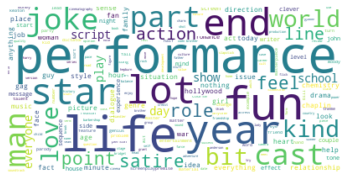

In [30]:
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [31]:
# df[df['review'].str.contains("arthur")]

In [32]:
# for t in range(lda.num_topics):
#     plt.figure()
#     plt.imshow(WordCloud().fit_words(dict(lda.show_topic(t, 200))))
#     plt.axis("off")
#     plt.title("Topic #" + str(t))
#     plt.show()

## Topic Modeling with LSA

In [33]:
cv = CountVectorizer(ngram_range=(1, 2), stop_words=removed_words, token_pattern="\\b[a-z][a-z]+\\b")
bow = cv.fit_transform(list_of_words)
bow.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [34]:
feature_names = cv.get_feature_names()
# feature_names

In [35]:
# bow_df = pd.DataFrame(bow.toarray(), columns=feature_names)
# bow_df.head()

In [36]:
lsa = TruncatedSVD(4)
doc_topic_2 = lsa.fit_transform(bow)
lsa.explained_variance_ratio_

array([0.04212205, 0.02120219, 0.01472392, 0.01208781])

In [37]:
topic_word = pd.DataFrame(lsa.components_.round(3),
             index = ["component_1","component_2", "component_3", "component_4"],
             columns = cv.get_feature_names())
# topic_word
# "component_5", "component_6", "component_7", "component_8", "component_9", "component_10"

In [38]:
display_topics(lsa, cv.get_feature_names(), 10)


Topic  0
issue, shout, martin, dirty, content, bonus, note, part, factory, scoundrel

Topic  1
life, performance, role, man, relationship, chaplin, end, play, barbershop, year

Topic  2
tracy, bullet, george, hepburn, family, hollywood, mike, criterion, member, genre

Topic  3
barbershop, stereotype, drama, experience, entertainer, fact, development, performance, dialogue, line


## Topic Modeling with LDA

In [39]:
stop_words = set(stopwords.words('english'))
# print(stop_words)
more_stopwords = ["movie", "comedy", "film", "director", "good", "great", "one", "year", "man", "humor", "laugh",
                  "like", "make", "best", "may", "even", "way", "still", "many", "often", "part", "star",
                  "something", "get", "also", "though", "would", "could", "ever", "made", "see", "watch", "tm", 
                  "pron", "mr", "thing", "actor", "time", "plot", "aaah", "aan", "ab", "il", "di", "si", "che", 
                  "ci", "le", "quando", "la", "da", "character", "story", "life", "moment", "scene", 
                  "performance", "end", "joke", "work", "lot", "role", "cast", "audience", "fun"]
non_words = stop_words.union(more_stopwords)
# "scene", "audience", "star", 
#                  "role", "genre", "story", "part", "work", "job", "year", "character", "performance", "life", 
#                  "moment", "man", "woman", "joke"

In [40]:
count_vectorizer = CountVectorizer(ngram_range=(1, 2),  
                                   stop_words=non_words, token_pattern="\\b[a-z][a-z]+\\b", max_df=.95)

count_vectorizer.fit(list_of_words)

In [41]:
document_word = count_vectorizer.transform(list_of_words).transpose()

In [42]:
pd.DataFrame(document_word.toarray(), count_vectorizer.get_feature_names()).head(2)

In [43]:
# document_word.shape
corpus = matutils.Sparse2Corpus(document_word)
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())
# len(id2word)

In [44]:
lda = models.LdaModel(corpus=corpus, num_topics=4, id2word=id2word, passes=15)

In [45]:
lda.print_topics()

In [46]:
for t in range(lda.num_topics):
    plt.figure()
    plt.imshow(WordCloud().fit_words(dict(lda.show_topic(t, 200))))
    plt.axis("off")
    plt.title("Topic #" + str(t))
    plt.show()

## Visualization with PCA

In [48]:
# X = np.array(doc_topic)
X = np.array(doc_topic)
X.shape

(3825, 5)

In [53]:
# Take all of the data and plot it on 2 dimensions
pca = PCA(n_components=2)
pca.fit(X)
X_pca = pca.transform(X)

In [54]:
# X_pca = pca.transform(X)
print("shape of original X:", X.shape)
print("shape of X using 2 principal components:", X_pca.shape, "\n")
print(X_pca)

shape of original X: (3825, 5)
shape of X using 2 principal components: (3825, 2) 

[[-0.00322943 -0.0079659 ]
 [-0.00588175  0.0066495 ]
 [-0.0053767   0.00678607]
 ...
 [-0.00316356  0.00597029]
 [ 0.00649513  0.01721065]
 [-0.00588081 -0.00999391]]


In [56]:
pca.explained_variance_ratio_

array([0.2827627 , 0.22171894])

In [57]:
# to understand the importance of each variable in each PC, look at the correlations:

graph_df = pd.DataFrame(X_pca, columns = ['PC1','PC2'])
graph_df.head()

# remember, signs don't matter, just direction in space

,PC1,PC2
0,-0.003229,-0.007966
1,-0.005882,0.006649
2,-0.005377,0.006786
3,-0.005034,0.012044
4,0.003808,-0.000543


In [58]:
df['type'].head()

0    critic
1    critic
2    critic
3    critic
4    critic
Name: type, dtype: object

In [59]:
graph_df.reset_index(drop=True, inplace=True)
# graph_df.head()

In [60]:
df.reset_index(drop=True, inplace=True)

In [61]:
# type(graph_df)

In [62]:
graph_df = graph_df.assign(test=pd.Series(df['type']))
# graph_df['test'] = df['type']

In [63]:
# graph_df.head()

In [64]:
graph_df.test = graph_df.test.replace(to_replace=['critic', 'audience'], value=[0, 1])

In [65]:
# graph_df.head()

In [66]:
# pca.singular_values_

In [67]:
y = np.array(graph_df['test'])
# y.shape
# X_pca.shape
# type(X_pca)

In [68]:
names = ['critic', 'audience']

In [69]:
# Create a plot of the PCA results
from itertools import cycle

def plot_PCA_2D(data, target, target_names):
    colors = cycle(['r','g','orange','w','aqua','yellow', 'r','g', 'b','c'])
    target_ids = range(len(target_names))
    plt.figure(figsize=(10,10))
    for i, c, label in zip(target_ids, colors, target_names):
        plt.scatter(data[target == i, 0], data[target == i, 1],
                   c=c, label=label, edgecolors='gray')
        plt.xlim(-0.05, 0.3)
        plt.ylim(-0.05, 0.7)
    plt.legend(fontsize=20)
    plt.tick_params(axis='both', which='major', labelsize=15)

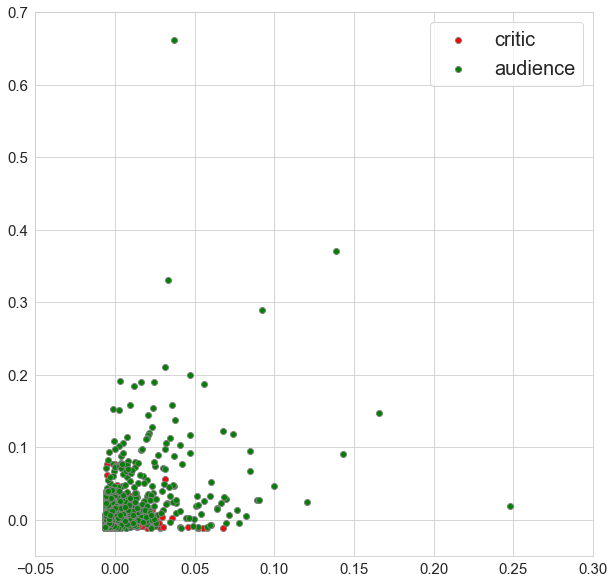

In [70]:
# plot of all the numbers
plot_PCA_2D(X_pca, target=y, target_names=names)

In [71]:
graph_df['PC1'].max()
# graph_df.iloc[df['PC1'].max()]

6.920109105191928